In [1]:
pip install -e .

Obtaining file:///home/natalie/nsalab/Users/naw1/desk2/dl/gym-child
  Attempting uninstall: gym-maze
    Found existing installation: gym-maze 0.4
    Uninstalling gym-maze-0.4:
      Successfully uninstalled gym-maze-0.4
  Running setup.py develop for gym-maze
Note: you may need to restart the kernel to use updated packages.


# Q Learning Training Environment

In [1]:
import gym
import gym_child
import numpy as np
import time
import sys
import math
import random

In [2]:
def get_explore_rate(t,min_explore_rate,decay_fact):
    return max(min_explore_rate, min(0.8, 1.0 - math.log10((t+1)/decay_fact)))


def get_learning_rate(t,min_learning_rate,decay_fact):
    return max(min_learning_rate, min(0.8, 1.0 - math.log10((t+1)/decay_fact)))

In [3]:
# variables: 
neps = 20
tstep = 200
min_explore_rate = 0.001
min_learning_rate = 0.2
#grid_size = tuple((env.observation_space.high + np.ones(env.observation_space.shape)).astype(int))
#decay_fact = np.prod(grid_size, dtype=float) / 10.0
decay_fact = np.prod((9,9),dtype=float)/10.0
#state_bounds = list(zip(env.observation_space.low, env.observation_space.high))
explore_rate = get_explore_rate(0,min_explore_rate,decay_fact)
learning_rate = get_learning_rate(0,min_learning_rate,decay_fact)

In [4]:
max_t = np.prod((9,9),dtype=int)*100
streak_to_end = 100
solved_t = np.prod((9,9),dtype=int)


In [5]:
def select_action(env,state, q_table,explore_rate):
    # Select a random action
    if random.random() < explore_rate:
        action = env.action_space.sample()
    # Select the action with the highest q
    else:
        action = int(np.argmax(q_table[state]))
    return action

In [6]:
def state_to_bucket(state,env):
    grid_size = tuple((env.observation_space.high + np.ones(env.observation_space.shape)).astype(int))
    state_bounds = list(zip(env.observation_space.low, env.observation_space.high))
    bucket_indice = []
    for i in range(len(state)):
        if state[i] <= state_bounds[i][0]:
            bucket_index = 0
        elif state[i] >= state_bounds[i][1]:
            bucket_index = grid_size[i] - 1
        else:
            # Mapping the state bounds to the bucket array
            bound_width = state_bounds[i][1] - state_bounds[i][0]
            offset = (grid_size[i]-1)*state_bounds[i][0]/bound_width
            scaling = (grid_size[i]-1)/bound_width
            bucket_index = int(round(scaling*state[i] - offset))
        bucket_indice.append(bucket_index)
    return tuple(bucket_indice)

In [7]:
def run_qlearn(env,q_table, explore_rate, learning_rate, neps=200,tstep=100):
    env.render()
    num_streaks = 0
    discount_factor = 0.99
    max_t = np.prod((9,9),dtype=int)*100
    streak_to_end = 100
    solved_t = np.prod((9,9),dtype=int)
    decay_fact = np.prod((9,9),dtype=float)/10.0
    
    for ep in range(neps):
        if ep == 0:
            time.sleep(5)
        obv = env.reset()
        print('------------'+str(ep))
        state_0 = state_to_bucket(obv,env)
        total_reward = 0
        
        for t in range(tstep):
            # select best action and execute
            action = select_action(env,state_0, q_table, explore_rate)
            obv,reward,done,_ = env.step(action)
            
            # update the state you are in, add reward (observe result)
            state = state_to_bucket(obv,env)
            total_reward += reward
            #print('cur' + str(reward))
            #print(total_reward)
            #print(reward, total_reward)
            
            # update Q-table
            best_q = np.amax(q_table[state])
            q_table[state_0 + (action,)] += learning_rate * (reward + discount_factor * (best_q) - q_table[state_0 + (action,)])
            
            # update state
            state_0 = state
            
            env.render()
            time.sleep(0.1)
            
            
            # update parameters
            #explore_rate = get_explore_rate(ep,min_explore_rate,decay_fact)
            #learning_rate = get_learning_rate(ep,min_learning_rate,decay_fact)
            
            if done:
                time.sleep(1)
                print("Episode %d finished after %f time steps with total reward = %f (streak %d)."
                      % (ep, t, total_reward, num_streaks))

                if t <= solved_t:
                    num_streaks += 1
                else:
                    num_streaks = 0
                break

            elif t >= max_t - 1:
                print("Episode %d timed out at %d with total reward = %f."
                      % (ep, t, total_reward))

        # It's considered done when it's solved over 120 times consecutively
        if num_streaks > streak_to_end:
            break
            
        explore_rate = get_explore_rate(ep,0.001,decay_fact)
        learning_rate = get_learning_rate(ep,0.2,decay_fact)
                
    return q_table

In [8]:
#Make Q Table 
q_table0 = np.zeros((9,9) + (4,), dtype=float)

In [9]:
# Run Training 
fin_q_table = run_qlearn(gym.make('maze-v0'),q_table0,explore_rate,learning_rate,neps=100,tstep=max_t)

pygame 2.1.2 (SDL 2.0.18, Python 3.7.12)
Hello from the pygame community. https://www.pygame.org/contribute.html
------------0
Episode 0 finished after 18.000000 time steps with total reward = -790.581122 (streak 0).
------------1


KeyboardInterrupt: 

In [15]:
fin_q_table.shape

(10, 10, 4)

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#### ACTION = ["N", "S", "E", "W"]

<AxesSubplot:>

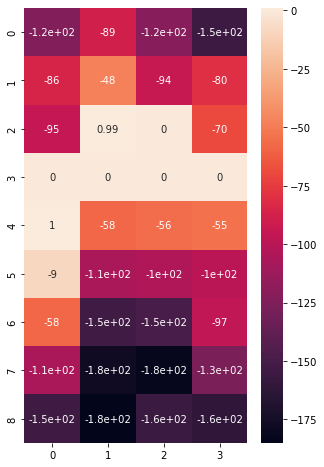

In [34]:
fig,ax = plt.subplots(figsize=(5,8))
sns.heatmap(fin_q_table[4,:,:],annot=True)

# Keras Deep Q Learning 
#### First model is a 3 Fully connected Layer model. 


In [10]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Convolution2D
from tensorflow.keras.optimizers import Adam
import gym
import gym_child
import numpy as np
import time
import sys
import math
import random
from matplotlib import pyplot as plt

In [11]:
def build_model(states, actions):
    model = Sequential()
    model.add(Flatten(input_shape=(1,states)))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [19]:
# Sometimes you must delete the model after building the DQN agent if an error is raised. 
# Then you must rebuild the model. This is a Keras dependency issue. 
# This is the error: AttributeError: 'Sequential' object has no attribute '_compile_time_distribution_strategy'
# Just restart the runn
del model

In [13]:
env = gym.make('maze-v0')
states = env.observation_space.shape[0]
actions = env.action_space.n

In [20]:
model = build_model(states, actions)

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2)                 0         
                                                                 
 dense (Dense)               (None, 24)                72        
                                                                 
 dense_1 (Dense)             (None, 24)                600       
                                                                 
 dense_2 (Dense)             (None, 4)                 100       
                                                                 
Total params: 772
Trainable params: 772
Non-trainable params: 0
_________________________________________________________________


In [16]:
from rl.agents import DQNAgent
from rl.policy import LinearAnnealedPolicy
from rl.policy import BoltzmannQPolicy
from rl.policy import GreedyQPolicy
from rl.memory import SequentialMemory
from rl.policy import EpsGreedyQPolicy

In [21]:
def build_agent(model, actions):
    #policy = EpsGreedyQPolicy()
    #policy = GreedyQPolicy()
    policy = BoltzmannQPolicy()
    #policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.05, nb_steps=10000)
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, 
                  nb_actions=actions, nb_steps_warmup=10, target_model_update=1e-1)
    return dqn

In [22]:
dqn = build_agent(model, actions)
dqn.compile(Adam(learning_rate=1e-1), metrics=['mae'])
fit = dqn.fit(env, nb_steps=50000, visualize=False, verbose=1)

Training for 50000 steps ...
Interval 1 (0 steps performed)
    1/10000 [..............................] - ETA: 9:58 - reward: -49.0000

C:\Users\asong18\Anaconda3\envs\deeplearning3.7\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
C:\Users\asong18\Anaconda3\envs\deeplearning3.7\lib\site-packages\rl\memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


10000/10000 [==============================] - 116s 12ms/step - reward: -48.0178
77 episodes - episode_reward: -6219.536 [-48780.220, 1.000] - loss: 5780.963 - mae: 1218.831 - mean_q: -1579.714

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 102s 10ms/step - reward: -37.6362
1532 episodes - episode_reward: -246.403 [-8316.519, 1.000] - loss: 522.747 - mae: 213.104 - mean_q: -231.314

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 111s 11ms/step - reward: -35.2668
1790 episodes - episode_reward: -197.103 [-409.457, 1.000] - loss: 463.446 - mae: 138.774 - mean_q: -126.650

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 119s 12ms/step - reward: -35.5980
1766 episodes - episode_reward: -201.574 [-776.450, 1.000] - loss: 542.689 - mae: 134.941 - mean_q: -119.485

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 114s 11ms/step - reward: -35.7350
done, took

In [23]:
scores = dqn.test(env, nb_episodes=100, visualize=False)
print(np.mean(scores.history['episode_reward']))
print(np.mean(scores.history['nb_steps']))

Testing for 100 episodes ...
Episode 1: reward: -138.287, steps: 4
Episode 2: reward: -239.878, steps: 6
Episode 3: reward: -200.904, steps: 6
Episode 4: reward: -236.287, steps: 6
Episode 5: reward: -295.915, steps: 8
Episode 6: reward: -292.836, steps: 8
Episode 7: reward: -9.002, steps: 2
Episode 8: reward: -293.000, steps: 7
Episode 9: reward: -105.455, steps: 4
Episode 10: reward: -190.878, steps: 5
Episode 11: reward: -203.455, steps: 6
Episode 12: reward: -58.002, steps: 3
Episode 13: reward: -298.904, steps: 8
Episode 14: reward: -138.287, steps: 4
Episode 15: reward: -251.424, steps: 7
Episode 16: reward: -249.904, steps: 7
Episode 17: reward: -201.839, steps: 6
Episode 18: reward: -298.904, steps: 8
Episode 19: reward: -197.915, steps: 6
Episode 20: reward: -298.904, steps: 8
Episode 21: reward: -187.287, steps: 5
Episode 22: reward: -250.839, steps: 7
Episode 23: reward: -200.904, steps: 6
Episode 24: reward: -187.287, steps: 5
Episode 25: reward: -152.839, steps: 5
Episode 

In [17]:
print(scores.history)

{'episode_reward': [-288.737825540498, -398.7248135528109, -202.28364907786704, -141.73782554049802, -398.7248135528109, -300.6237029910219, -188.4500063479209, -239.8778131229112, -300.7248135528109, -251.42367369016267, -41.65724720087715, -398.7248135528109, -253.1168556472544, -151.63290625010146, -350.7831998327947, -89.28682365201874, -205.00182824684458, -246.06176851920745, -253.1168556472544, -156.00182824684458, -90.45000634792088, -97.0, -103.8390198678934, -202.87388917961925, -288.737825540498, -202.28364907786704, -102.90438076169968, -205.00182824684458, -151.63290625010146, -246.06176851920745, -104.87973748005228, -239.73782554049802, -56.45527836869272, -41.65724720087715, 1.0, -254.00182824684458, -254.00182824684458, -300.7248135528109, -141.73782554049802, -337.7378255404981, -156.00182824684458, -139.45000634792086, -41.65724720087715, -237.4500063479209, -300.7248135528109, -58.001828246844575, -156.00182824684458, -190.73782554049802, -188.4500063479209, -204.53

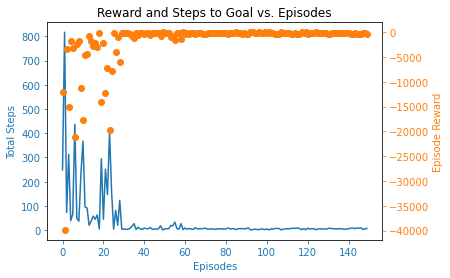

In [11]:
import matplotlib.pyplot as plt
# length = len(fit.history['nb_episode_steps'])
length = 150
fig = plt.figure()
#plt.title("Reward and Steps to Goal vs. Episodes")
ax = fig.add_subplot(111, label="1")
ax2 = fig.add_subplot(111, label="2", frame_on=False)
ax.plot(range(length), fit.history['nb_episode_steps'][:length], color="C0")
ax.set_xlabel("Episodes", color="C0")
ax.set_ylabel("Total Steps", color="C0")
ax.tick_params(axis='x', colors="C0")
ax.tick_params(axis='y', colors="C0")
ax2.scatter(range(length), fit.history['episode_reward'][:length], color="C1")
ax2.axes.get_xaxis().set_visible(False)
ax2.yaxis.tick_right()
ax2.set_ylabel('Episode Reward', color="C1")
ax2.yaxis.set_label_position('right')
ax2.tick_params(axis='y', colors="C1")
ax.set_title("Reward and Steps to Goal vs. Episodes")
fig.savefig(f"Thresholded_Deep_Q_learn_{length}eps_lr_1e-1")

In [13]:
print(len(fit.history['episode_reward']))
print(fit.history)

243
{'episode_reward': [-13924.68327828366, -19106.605708130104, -14273.019524838617, -337.8778131229112, -97975.18331034211, -97933.2905716733, -97997.73229764444, -97981.19689766792, -98000.0, -98000.0, -4064.2793270604757, -97954.96667122903, -1606.8649527029024, -1905.1833562521724, -86823.86733912512, -536.9637957352187, -3844.6080759968886, -1265.286823652019, -17884.603694321948, -489.0, -934.2460027461971, -10478.087066730566, -10253.308598455571, -4136.903365380145, -1978.265352225413, -1512.9706343578894, -90.7557223561189, -4210.015067517639, -11592.499906311778, -10324.673693318427, -3658.650707242489, -1006.017653792547, -22092.546913620175, -10191.675839037753, -194.79275914704374, -15132.288548283499, -1462.957988062637, -12501.397666349643, -12856.242521534467, 1.0, -243.79275914704374, -3127.18245017147, -497.45527836869275, 1.0, -14269.422511673685, -24734.447941892042, -15228.7238470354, -6758.584580404753, -283.49443882192594, -55893.953351086806, -591.1905493215634